## Importing the relevant libraries

In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import all the necessary model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model, load_model

from IPython.display import display, Image
import time

#from tensorflow.keras.applications import Xception

In [ ]:
# change colab flag to false if train using jupyter notebook else set to true if using colab
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [ ]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


## Import the numpy (.npz) file consisting our training images
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [ ]:
INPUT_SHAPE = (128,128,3)
#INPUT_SHAPE = (192,192,3)
#INPUT_SHAPE = (224,224,3) # this one hit colab ram restriction :(
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
print(NPZ_PATH)

./drive/My Drive/4041-dog-breed-classification/Datasets/preprocessed_data_192x192.npz


In [ ]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [ ]:
# loading the npz file
import gc
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
del loaded
gc.collect()

print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 23.552701950073242


In [ ]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 192, 192, 3)
-  dtype	 float16
- nbytes	 2260942848 (2.11 GB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [ ]:
# check the numpy array values whether is it normalised or not
loaded_X[50][0][:7]

array([[0.6904, 0.639 , 0.5728],
       [0.5806, 0.5293, 0.4626],
       [0.298 , 0.2471, 0.1843],
       [0.3333, 0.2783, 0.2274],
       [0.2666, 0.2118, 0.1686],
       [0.2354, 0.1843, 0.153 ],
       [0.251 , 0.2   , 0.1686]], dtype=float16)

In [ ]:
loaded_Y[50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [ ]:
dict_breeds

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

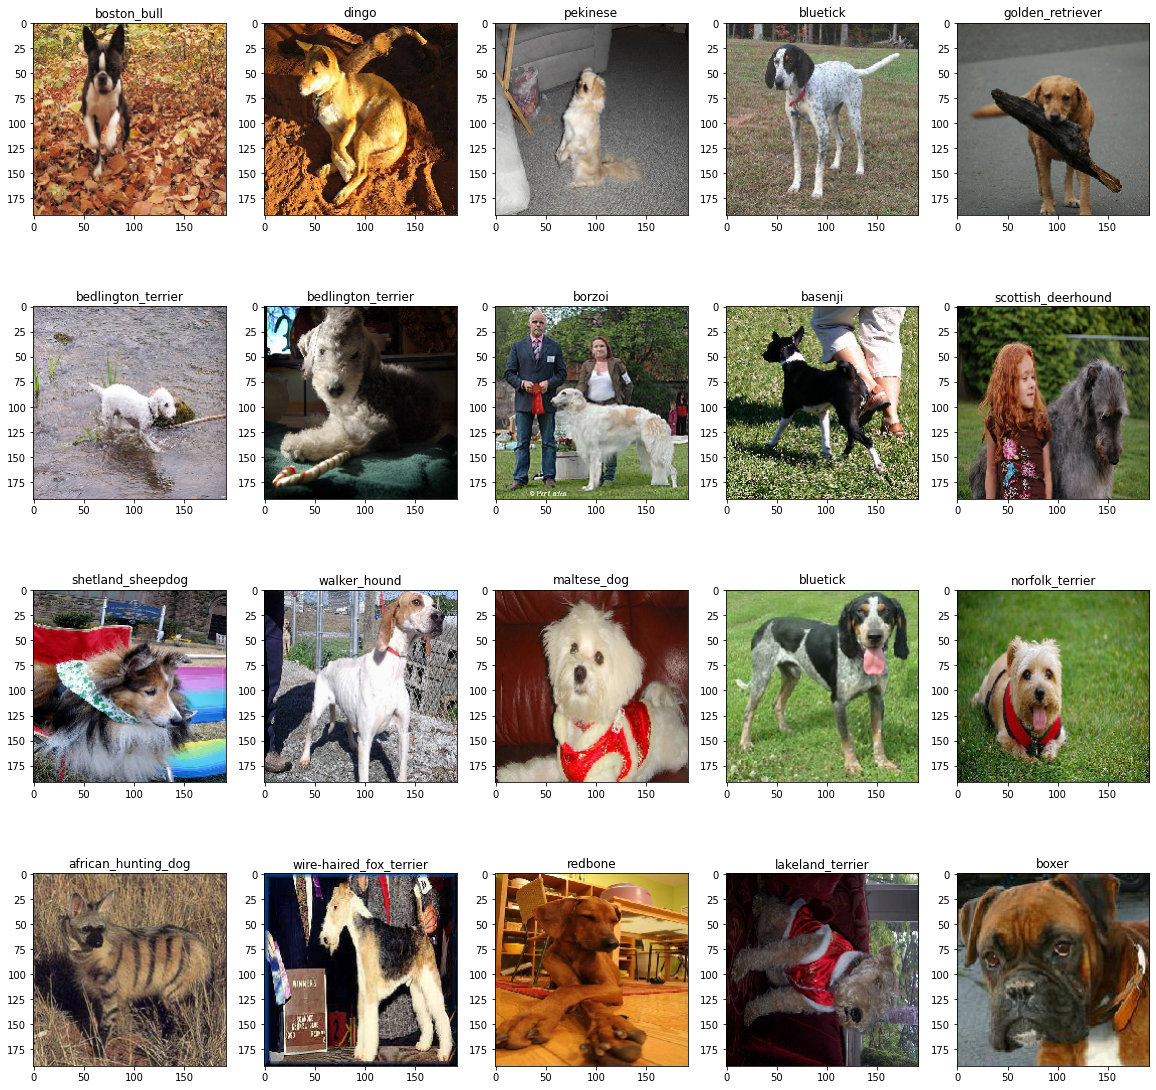

In [ ]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(loaded_Y[i]==1)[0][0]])
    plt.imshow(loaded_X[i].astype('float32'))

## Split data into train and val

In [ ]:
# perform train test split to get training and validation data
X_train, X_val, y_train, y_val = train_test_split(loaded_X, loaded_Y, train_size=0.8,random_state=42)

In [ ]:
del loaded_X
del loaded_Y

## Image Augmentation

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# --- MODEL BUILDING ---

### Helper Function

In [ ]:
# for plotting
def plot_model_history(history, folder=COLAB_FILEPATH+"plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")

    plt.title(f"Model Loss - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title(f"Model Accuracy - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name+'.jpg')
    plt.show()

def plot_learning_rate(history, folder="plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

In [ ]:
# function to train the model
def train_model(model_name,pre_trained_model,batch_size,epochs,lr,optimizer,input_shape=INPUT_SHAPE,Xtrain=X_train,Xval=X_val,ytrain=y_train,yval=y_val):
    # initialise saved weights filename
    filename = f'{model_name}_{input_shape[0]}x{input_shape[1]}_bs-{batch_size}_lr-{lr}_ep-{epochs}'

    # define callbacks
    saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}models/{filename}.h5',save_best_only=True,verbose=1)
    reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # retrieve base model
    base = pre_trained_model

    # freeze pre-trained weight
    base.trainable = True

    # rebuild output layer
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(120, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    #model.summary()

    # Compiling the model
    model.compile(optimizer=optimizer, 
                  loss = 'categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # train model
    H = model.fit(train_datagen.flow(Xtrain,ytrain,
                                    batch_size=batch_size,
                                    shuffle=True),
                  epochs=epochs,
                  steps_per_epoch=Xtrain.shape[0]//batch_size,
                  validation_data=(Xval,yval),
                  callbacks=[saved_weights, reduced_lr, early_stopping]
              )
    
    return H, filename

In [ ]:
# load the different pre-trained models
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201

In [ ]:
# function to load the specific model
def load_pretrained_model(name):
    if name == 'DenseNet121':
        model = DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'DenseNet169':
        model = DenseNet169(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'DenseNet201':
        model = DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'Xception':
        model = Xception(include_top=False,weights="imagenet", input_shape=INPUT_SHAPE)
    elif name == 'VGG16':
        model = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'VGG19':
        model = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE) 
    elif name == 'ResNet50':
        model = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'ResNet101':
        model = ResNet101(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'ResNet152':
        model = ResNet152(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'ResNet50V2':
        model = ResNet50V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'ResNet101V2':
        model = ResNet101V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'ResNet152V2':
        model = ResNet152V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'InceptionV3':
        model = InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'InceptionResNetV2':
        model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'MobileNet':
        model = MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif name == 'MobileNetV2':
        model = MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    else:
        model = "model not defined"

    return name, model

# ------ TRAINING OF MODELS ------
#### ------ EXAMPLE OF THE TRAINING WITH 3 EPOCHS ------

In [ ]:
# hyperparameters configuration
BATCH_SIZE = 64
EPOCHS = 3
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

In [ ]:
# DenseNet121
name, model = load_pretrained_model('DenseNet121')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)

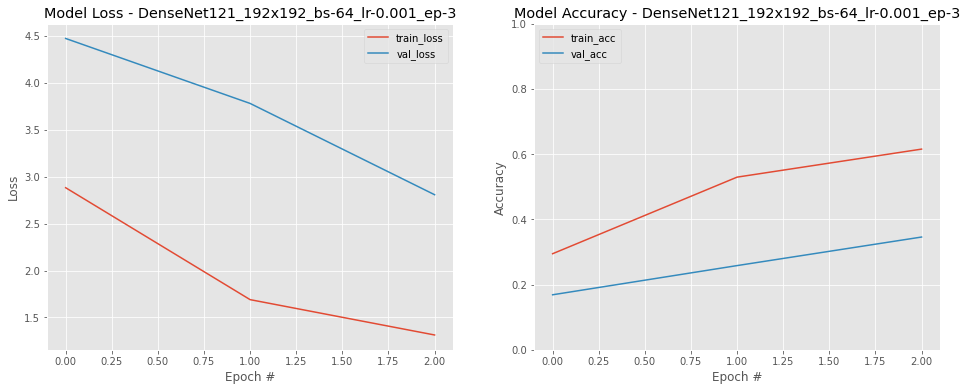

In [ ]:
# plot model performance
plot_model_history(H, saving_name=filename)

### ----- ACTUAL TRAINING -----
#### ----- WITH 50 EPOCHS -----

In [ ]:
# hyperparameters configuration
BATCH_SIZE = 64
EPOCHS = 50
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

#### The models

Epoch 1/50
127/127 [==============================] - 143s 761ms/step - loss: 3.5458 - accuracy: 0.2109 - val_loss: 4.6922 - val_accuracy: 0.0978

Epoch 00001: val_loss improved from inf to 4.69215, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet121_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 86s 678ms/step - loss: 1.7051 - accuracy: 0.5187 - val_loss: 3.8371 - val_accuracy: 0.1751

Epoch 00002: val_loss improved from 4.69215 to 3.83712, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet121_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 86s 678ms/step - loss: 1.2641 - accuracy: 0.6368 - val_loss: 2.4629 - val_accuracy: 0.3672

Epoch 00003: val_loss improved from 3.83712 to 2.46285, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet121_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 4/50
127/127 [==============================] - 8

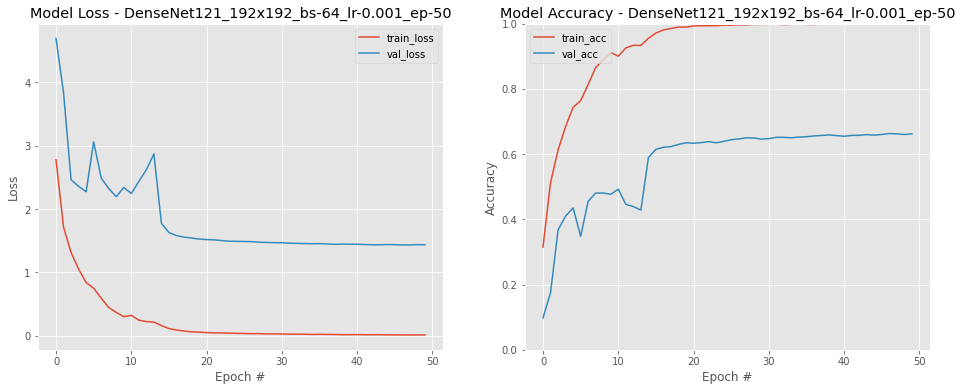

In [ ]:
# DenseNet121
name, model = load_pretrained_model('DenseNet121')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

Epoch 1/50
127/127 [==============================] - 240s 1s/step - loss: 3.5961 - accuracy: 0.1906 - val_loss: 4.4068 - val_accuracy: 0.1413

Epoch 00001: val_loss improved from inf to 4.40681, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet169_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 168s 1s/step - loss: 1.7547 - accuracy: 0.5098 - val_loss: 3.1680 - val_accuracy: 0.2474

Epoch 00002: val_loss improved from 4.40681 to 3.16805, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet169_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 169s 1s/step - loss: 1.3304 - accuracy: 0.6078 - val_loss: 2.5150 - val_accuracy: 0.3721

Epoch 00003: val_loss improved from 3.16805 to 2.51499, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet169_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 4/50
127/127 [==============================] - 169s 1s/

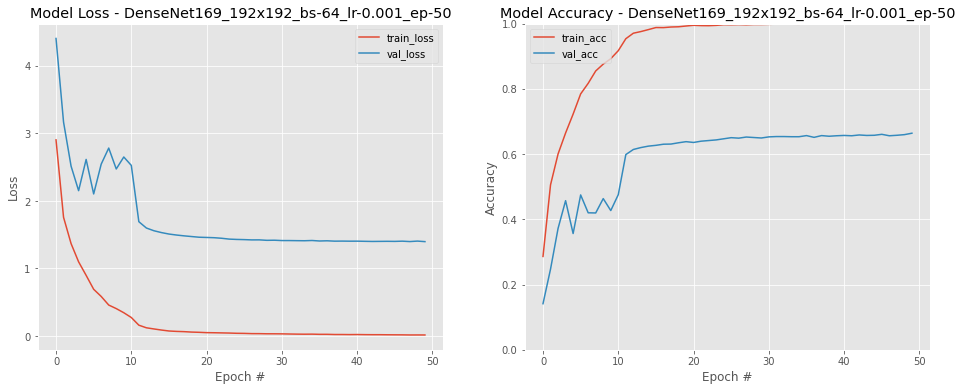

In [ ]:
# DenseNet169
name, model = load_pretrained_model('DenseNet169')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 136s 689ms/step - loss: 3.4890 - accuracy: 0.2100 - val_loss: 5.0841 - val_accuracy: 0.1066

Epoch 00001: val_loss improved from inf to 5.08415, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet201_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 79s 621ms/step - loss: 1.7963 - accuracy: 0.5059 - val_loss: 3.2643 - val_accuracy: 0.2851

Epoch 00002: val_loss improved from 5.08415 to 3.26430, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet201_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 79s 621ms/step - loss: 1.2931 - accuracy: 0.6169 - val_loss: 2.6846 - val_accuracy: 0.3775

Epoch 00003: val_loss improved from 3.26430 to 2.68459, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet201_192x192_bs-64_lr-0.001

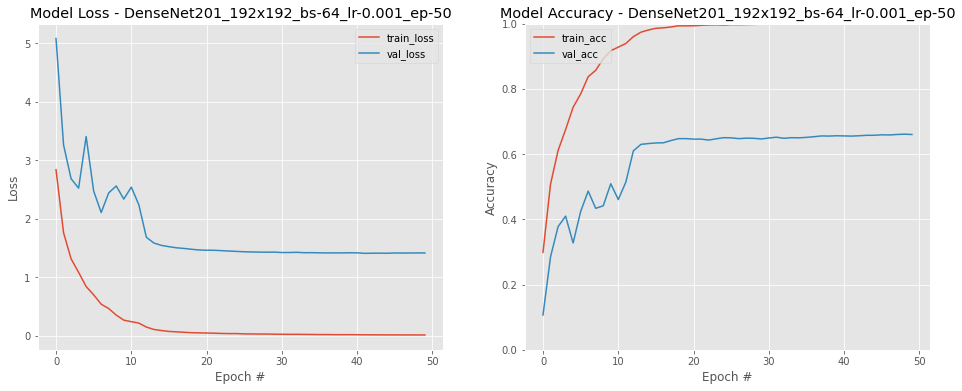

In [ ]:
# DenseNet201
name, model = load_pretrained_model('DenseNet201')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/50
127/127 [==============================] - 172s 1s/step - loss: 2.9173 - accuracy: 0.3282 - val_loss: 2.4217 - val_accuracy: 0.4088

Epoch 00001: val_loss improved from inf to 2.42174, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 124s 973ms/step - loss: 1.1436 - accuracy: 0.6666 - val_loss: 2.3569 - val_accuracy: 0.4034

Epoch 00002: val_loss improved from 2.42174 to 2.35694, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 124s 974ms/step - loss: 0.8385 - accuracy: 0.7436 - val_loss: 2.0711 - val_accuracy: 0.4870

Epoch 00003: val_loss improved from 2.35694 to 2.07107, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_192x192_bs-64_lr-0.001_ep-50.h5


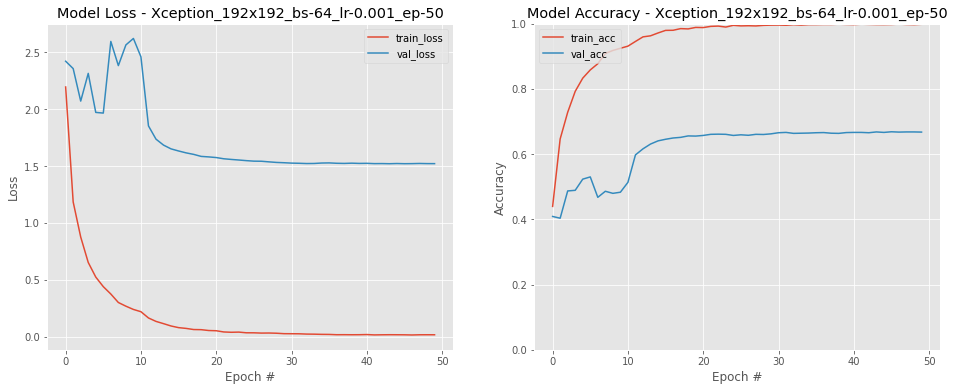

In [ ]:
# Xception
name, model = load_pretrained_model('Xception')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 158s 887ms/step - loss: 4.9400 - accuracy: 0.0096 - val_loss: 4.7864 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 4.78643, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG16_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 88s 692ms/step - loss: 4.7855 - accuracy: 0.0073 - val_loss: 4.7855 - val_accuracy: 0.0098

Epoch 00002: val_loss improved from 4.78643 to 4.78548, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG16_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 88s 692ms/step - loss: 4.7840 - accuracy: 0.0131 - val_loss: 4.7848 - val_accuracy: 0.0098

Epoch 00003: val_loss improved from 4.78548 to 4.78476, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG16_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 4/

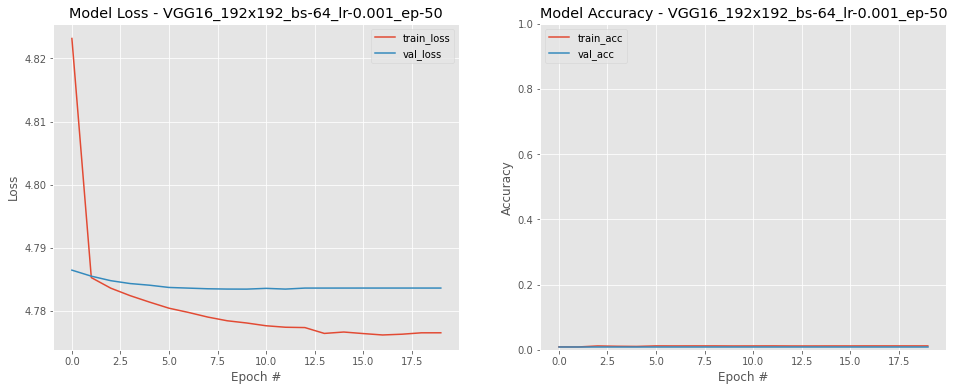

In [ ]:
# VGG16
name, model = load_pretrained_model('VGG16')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 168s 957ms/step - loss: 6.7709 - accuracy: 0.0078 - val_loss: 4.7864 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 4.78642, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG19_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 96s 752ms/step - loss: 4.7858 - accuracy: 0.0102 - val_loss: 4.7856 - val_accuracy: 0.0108

Epoch 00002: val_loss improved from 4.78642 to 4.78560, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG19_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 96s 750ms/step - loss: 4.7837 - accuracy: 0.0121 - val_loss: 4.7849 - val_accuracy: 0.0098

Epoch 00003: val_loss improved from 4.78560 to 4.78492, saving model to ./drive/My Drive/4041-dog-breed-classification/models/VGG19_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 4/

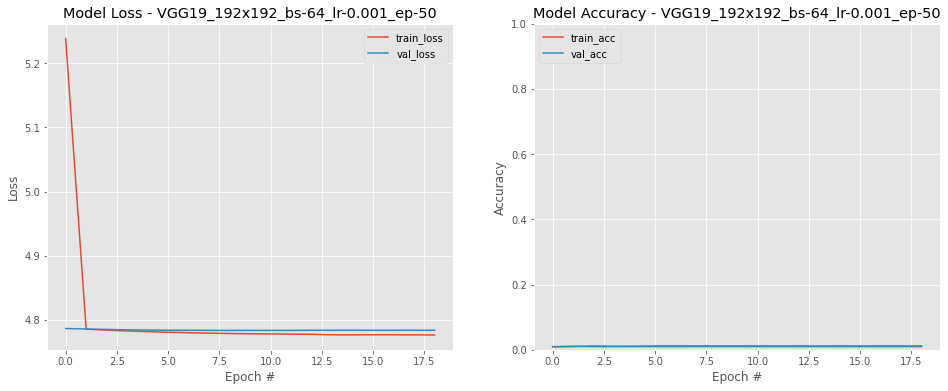

In [ ]:
# VGG19
name, model = load_pretrained_model('VGG19')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 181s 1s/step - loss: 4.4158 - accuracy: 0.0738 - val_loss: 5.8518 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 5.85176, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet50_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 137s 1s/step - loss: 2.7131 - accuracy: 0.3004 - val_loss: 5.0443 - val_accuracy: 0.0112

Epoch 00002: val_loss improved from 5.85176 to 5.04426, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet50_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 137s 1s/step - loss: 2.1219 - accuracy: 0.4135 - val_loss: 5.2772 - val_accuracy: 0.0073

Epoch 00003: val_loss did not improve from 5.04426
Epoch 4/50
127/127 [==============================] - 137s 1s/step - loss: 1.6940 - accuracy: 0.5272 - val_loss: 6.6492 - 

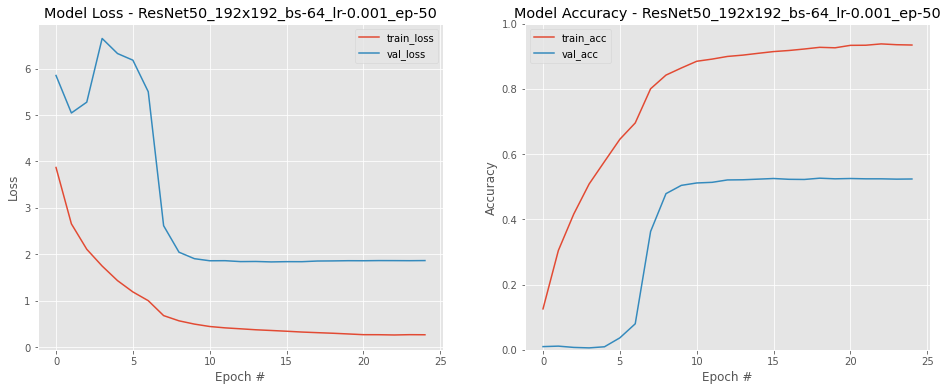

In [ ]:
# ResNet50
name, model = load_pretrained_model('ResNet50')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

171450368/171446536 [==============================] - 2s 0us/step
Epoch 1/50
127/127 [==============================] - 282s 2s/step - loss: 4.9828 - accuracy: 0.0186 - val_loss: 39.6884 - val_accuracy: 0.0054

Epoch 00001: val_loss improved from inf to 39.68840, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 232s 2s/step - loss: 4.4506 - accuracy: 0.0349 - val_loss: 5.3277 - val_accuracy: 0.0064

Epoch 00002: val_loss improved from 39.68840 to 5.32769, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 232s 2s/step - loss: 3.9404 - accuracy: 0.0859 - val_loss: 5.3157 - val_accuracy: 0.0068

Epoch 00003: val_loss improved from 5.32769 to 5.31566, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101_192x192_bs-64_lr-0.001_ep-50.h

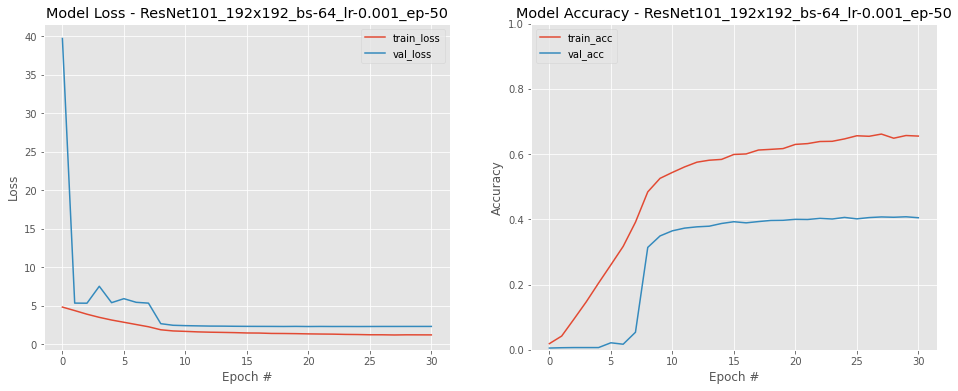

In [ ]:
# ResNet101
name, model = load_pretrained_model('ResNet101')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

Epoch 1/50
127/127 [==============================] - 383s 3s/step - loss: 5.0543 - accuracy: 0.0146 - val_loss: 26.9903 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 26.99026, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet152_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 324s 3s/step - loss: 4.7921 - accuracy: 0.0121 - val_loss: 5.1389 - val_accuracy: 0.0103

Epoch 00002: val_loss improved from 26.99026 to 5.13889, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet152_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 325s 3s/step - loss: 4.7700 - accuracy: 0.0143 - val_loss: 4.9667 - val_accuracy: 0.0103

Epoch 00003: val_loss improved from 5.13889 to 4.96672, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet152_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 4/50
127/127 [==============================] - 326s 3s/ste

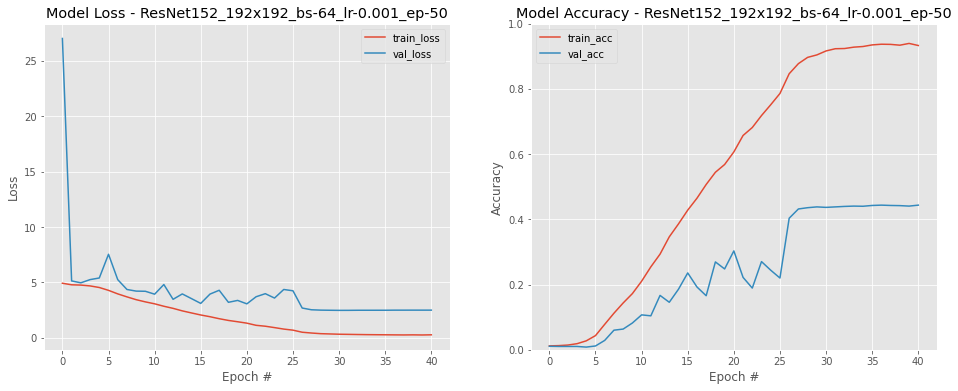

In [ ]:
# ResNet152
name, model = load_pretrained_model('ResNet152')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 132s 722ms/step - loss: 4.2583 - accuracy: 0.0743 - val_loss: 5.4646 - val_accuracy: 0.0616

Epoch 00001: val_loss improved from inf to 5.46458, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet50V2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 83s 649ms/step - loss: 2.9470 - accuracy: 0.2379 - val_loss: 3.7879 - val_accuracy: 0.1496

Epoch 00002: val_loss improved from 5.46458 to 3.78787, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet50V2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 83s 651ms/step - loss: 2.3673 - accuracy: 0.3596 - val_loss: 3.5034 - val_accuracy: 0.1990

Epoch 00003: val_loss improved from 3.78787 to 3.50339, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet50V2_192x192_bs-64_lr-0.001_ep

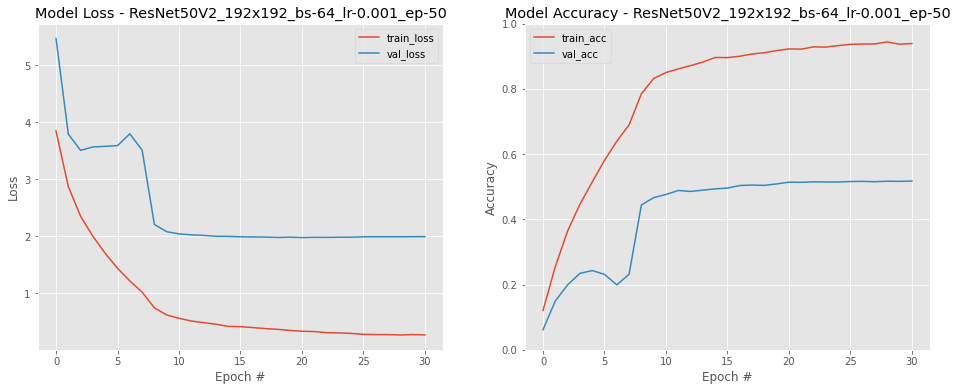

In [ ]:
# ResNet50V2
name, model = load_pretrained_model('ResNet50V2')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

171319296/171317808 [==============================] - 3s 0us/step
Epoch 1/50
127/127 [==============================] - 172s 1s/step - loss: 4.6173 - accuracy: 0.0420 - val_loss: 11.6989 - val_accuracy: 0.0230

Epoch 00001: val_loss improved from inf to 11.69893, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101V2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 128s 1s/step - loss: 3.6687 - accuracy: 0.1185 - val_loss: 5.5337 - val_accuracy: 0.0597

Epoch 00002: val_loss improved from 11.69893 to 5.53369, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101V2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 128s 1s/step - loss: 3.0343 - accuracy: 0.2238 - val_loss: 4.3283 - val_accuracy: 0.0680

Epoch 00003: val_loss improved from 5.53369 to 4.32831, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet101V2_192x192_bs-64_lr-0.001_e

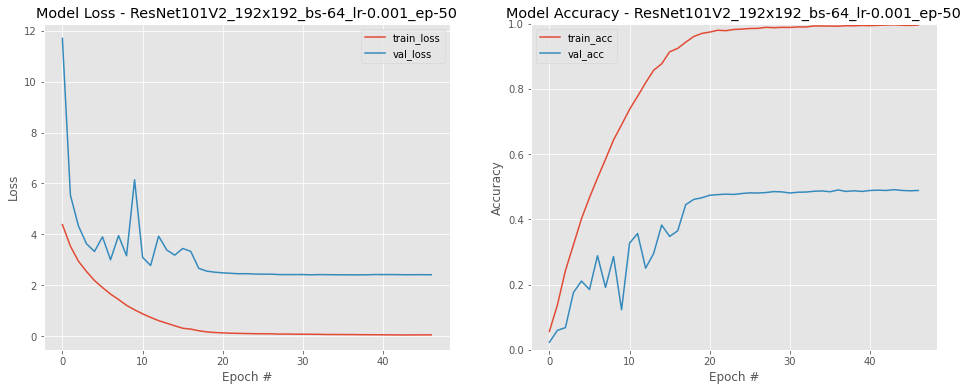

In [ ]:
# ResNet101V2
name, model = load_pretrained_model('ResNet101V2')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet152V2
name, model = load_pretrained_model('ResNet152V2')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/50
127/127 [==============================] - 214s 1s/step - loss: 4.7922 - accuracy: 0.0211 - val_loss: 2270.8154 - val_accuracy: 0.0103

Epoch 00001: val_loss improved from inf to 2270.81543, saving model to ./drive/My Drive/4041-dog-breed-classification/models/ResNet152V2_192x192_bs-64_lr-0.001_ep-50.h5


87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/50
127/127 [==============================] - 127s 672ms/step - loss: 3.9867 - accuracy: 0.1337 - val_loss: 5.1860 - val_accuracy: 0.0616

Epoch 00001: val_loss improved from inf to 5.18600, saving model to ./drive/My Drive/4041-dog-breed-classification/models/InceptionV3_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 76s 597ms/step - loss: 2.3177 - accuracy: 0.3801 - val_loss: 4.0010 - val_accuracy: 0.1267

Epoch 00002: val_loss improved from 5.18600 to 4.00100, saving model to ./drive/My Drive/4041-dog-breed-classification/models/InceptionV3_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 76s 596ms/step - loss: 1.7777 - accuracy: 0.5010 - val_loss: 3.8755 - val_accuracy: 0.1511

Epoch 00003: val_loss improved from 4.00100 to 3.87553, saving model to ./drive/My Drive/4041-dog-breed-classification/models/InceptionV3_192x192_bs-64_lr-0.001

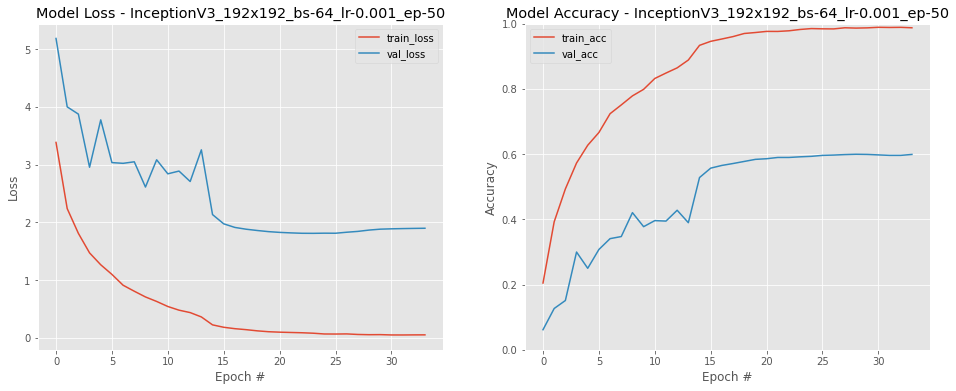

In [ ]:
# InceptionV3
name, model = load_pretrained_model('InceptionV3')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/50
127/127 [==============================] - 320s 2s/step - loss: 3.4644 - accuracy: 0.2239 - val_loss: 6.2771 - val_accuracy: 0.0117

Epoch 00001: val_loss improved from inf to 6.27714, saving model to ./drive/My Drive/4041-dog-breed-classification/models/InceptionResNetV2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 256s 2s/step - loss: 1.6210 - accuracy: 0.5389 - val_loss: 4.2829 - val_accuracy: 0.1922

Epoch 00002: val_loss improved from 6.27714 to 4.28292, saving model to ./drive/My Drive/4041-dog-breed-classification/models/InceptionResNetV2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 255s 2s/step - loss: 1.0449 - accuracy: 0.6765 - val_loss: 7.1612 - val_accuracy: 0.3071

Epoch 00003: val_loss did not improve from 4.28292
Epoch 4/50
127/127 [==============================] - 255s 2s/step - loss: 0.8192 - accuracy: 0.7526 -

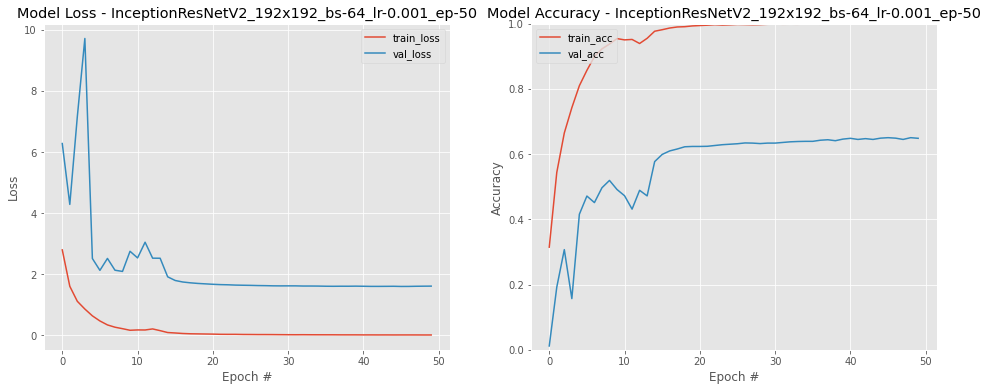

In [ ]:
# InceptionResNetV2
name, model = load_pretrained_model('InceptionResNetV2')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/50
127/127 [==============================] - 128s 751ms/step - loss: 3.4316 - accuracy: 0.2477 - val_loss: 4.6411 - val_accuracy: 0.1496

Epoch 00001: val_loss improved from inf to 4.64106, saving model to ./drive/My Drive/4041-dog-breed-classification/models/MobileNet_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 91s 715ms/step - loss: 1.3117 - accuracy: 0.6178 - val_loss: 3.3170 - val_accuracy: 0.2797

Epoch 00002: val_loss improved from 4.64106 to 3.31703, saving model to ./drive/My Drive/4041-dog-breed-classification/models/MobileNet_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 90s 709ms/step - loss: 0.8862 - accuracy: 0.7387 - val_loss: 3.5372 - val_accuracy: 0.2655

Epoch 00003: val_loss did not improve from 3.31703
Epoch 4/50
127/127 [==============================] - 90s 703ms/step - loss: 0.6847 - accuracy: 0.7879 - val_loss

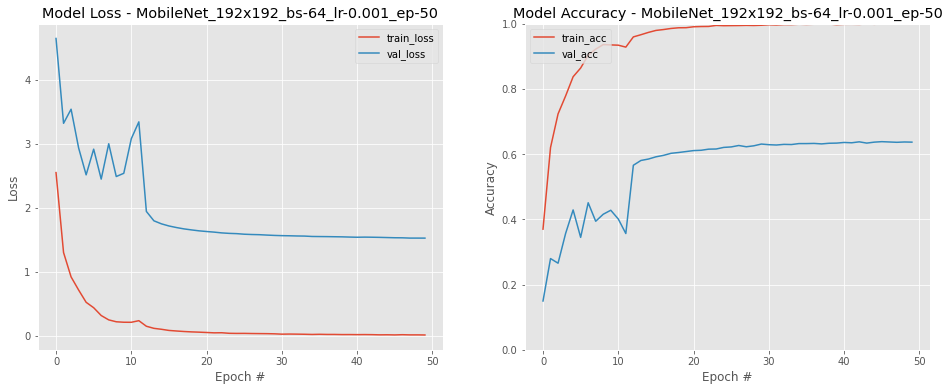

In [ ]:
# MobileNet
name, model = load_pretrained_model('MobileNet')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/50
127/127 [==============================] - 113s 604ms/step - loss: 3.1540 - accuracy: 0.2798 - val_loss: 10.7206 - val_accuracy: 0.0416

Epoch 00001: val_loss improved from inf to 10.72057, saving model to ./drive/My Drive/4041-dog-breed-classification/models/MobileNetV2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 2/50
127/127 [==============================] - 72s 564ms/step - loss: 1.4378 - accuracy: 0.5776 - val_loss: 10.6275 - val_accuracy: 0.0626

Epoch 00002: val_loss improved from 10.72057 to 10.62752, saving model to ./drive/My Drive/4041-dog-breed-classification/models/MobileNetV2_192x192_bs-64_lr-0.001_ep-50.h5
Epoch 3/50
127/127 [==============================] - 71s 558ms/step - loss: 1.1068 - accuracy: 0.6733 - val_loss: 7.4425 - val_accuracy: 0.1159

Epoch 00003: val_loss improved from 10.62752 to 7.44249, saving model to ./drive/My Drive/4041-dog-breed-classification/models/MobileNetV2_192x192_bs-64_lr-0

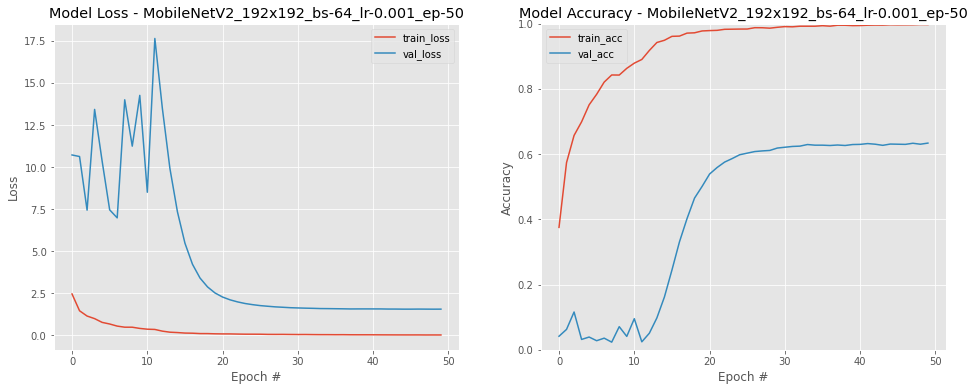

In [ ]:
# MobileNetV2
name, model = load_pretrained_model('MobileNetV2')
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

# --- TRAINING ENDS ---

## ------ LOAD SAVED MODEL ------
Load the model that gives the best validation accuracy

In [ ]:
# model configuration
pre_trained_name = 'DenseNet121'
load_input_shape = f'{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}'
load_bs = 128
load_lr = 0.001
load_ep = 3

In [ ]:
# DenseNet121
SAVED_MODEL = f'models/{pre_trained_name}_{load_input_shape}_bs-{load_bs}_lr-{load_lr}_ep-{load_ep}.h5'
model = load_model(f'{COLAB_FILEPATH}{SAVED_MODEL}', compile=False)

## ------ LOAD PRE-PROCESSED TEST DATA ------

In [ ]:
NPZ_PATH_TEST = f'{COLAB_FILEPATH}Datasets/preprocessed_data_test_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'

In [ ]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH_TEST)
print(loaded.files)
loaded_X_test = loaded["X"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X']
Time taken to load compressed data: 14.596900939941406


In [ ]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X_test)

Images (npz)
-  shape	 (10357, 128, 128, 3)
-  dtype	 float16
- nbytes	 1018134528 (970.97 MB)


In [ ]:
# check the numpy array values whether is it normalised or not
loaded_X_test[50][0][:7]

array([[0.153 , 0.153 , 0.153 ],
       [0.0745, 0.0745, 0.0745],
       [0.1059, 0.1059, 0.1059],
       [0.0902, 0.0902, 0.0902],
       [0.098 , 0.098 , 0.098 ],
       [0.0902, 0.0902, 0.0902],
       [0.1137, 0.1137, 0.1137]], dtype=float16)

## Test the pre-processed data with our model

In [ ]:
pred = model.predict(loaded_X_test)

In [ ]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {breeds[np.argmax(pred[0])]}")

[8.16701911e-03 1.79873575e-02 4.14009817e-04 1.45053910e-03
 1.70974783e-03 4.79763985e-05 9.12821197e-05 3.34438519e-04
 8.54248792e-05 1.99376978e-03 3.84293759e-04 1.90734499e-05
 1.56746231e-04 3.15755577e-04 3.35524703e-04 8.79256622e-05
 1.86836682e-04 2.16515575e-04 1.51107097e-02 1.00501347e-04
 1.74851462e-04 2.05035554e-03 7.97395501e-03 2.24684421e-02
 5.38565801e-04 1.96258500e-02 2.63304496e-03 3.11577787e-05
 1.32098474e-04 3.80135095e-03 7.60633498e-02 7.10102540e-06
 1.32873669e-04 1.04804058e-02 3.87063337e-04 6.19893399e-05
 1.96516281e-04 9.42518376e-03 4.42970522e-05 3.84999694e-05
 2.70574266e-04 2.17597131e-04 3.23448239e-06 4.84156236e-03
 9.27553338e-05 2.33508344e-03 2.71531608e-04 1.91463943e-04
 2.10050101e-04 4.69513470e-04 6.83321014e-06 3.40744900e-03
 6.86447695e-02 3.33016324e-05 5.81967353e-04 1.78887305e-04
 6.81246456e-05 2.24511459e-04 1.28590866e-04 2.92365992e-04
 9.36016906e-04 9.59447492e-03 5.80904307e-03 8.85910194e-05
 4.46623235e-05 1.875120

In [ ]:
preds_df = pd.DataFrame(columns=["id"] + list(breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


# --- KIV FIRST FROM THIS PORTION ONWARDS ---
##### --- WAIT UNTIL I FREE THEN DO :( ---

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = f'{COLAB_FILEPATH}Datasets/'
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,labels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sample_submission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,xception_test_weights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,preprocessed_data_test_128x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,preprocessed_data_128x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()